In [41]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [42]:
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "00",
    seed=123,
    shuffle=True,
    image_size=(640,240),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 10 classes.


In [44]:
class_names=dataset.class_names
class_names

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [45]:
print(len(class_names))

10


In [46]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 640, 240, 3)
[8 5 9 7 6 9 5 1 8 2 3 3 4 6 1 1 9 6 2 7 1 7 3 5 2 4 8 9 3 5 2 8]


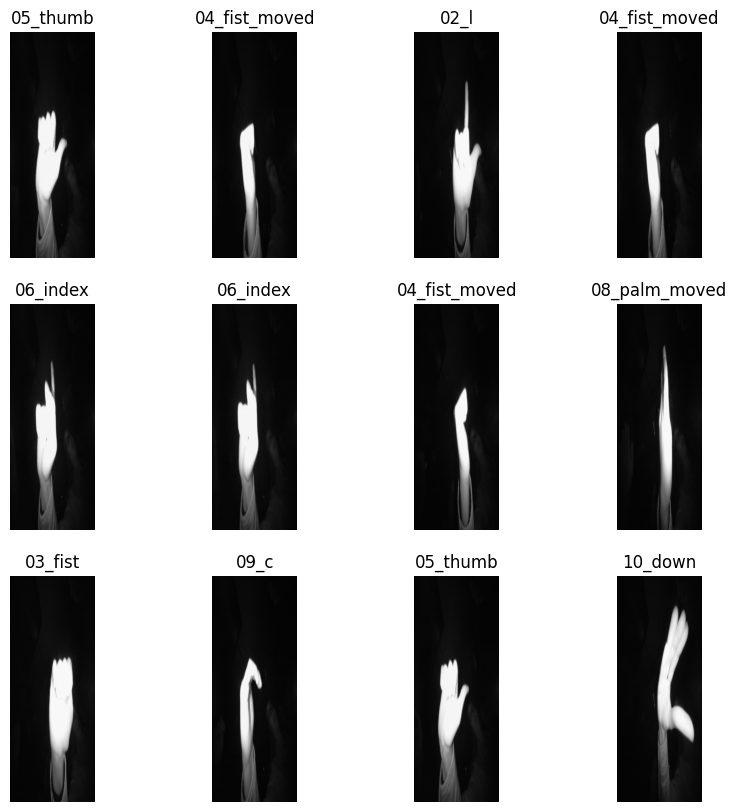

In [47]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [48]:
len(dataset)

63

In [49]:
train_size=0.8
len(dataset)*train_size

50.400000000000006

In [50]:
train_ds=dataset.take(50)
len(train_ds)

50

In [51]:
test_ds=dataset.skip(50)
len(test_ds)

13

In [52]:
val_size=0.1
len(dataset)*val_size

6.300000000000001

In [53]:
test_ds=test_ds.skip(6)
len(test_ds)

7

In [54]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [55]:
train_ds,val_ds,tevst_ds=get_dataset_partitions_tf(dataset)

In [56]:
len(train_ds)

50

In [57]:
len(val_ds)

6

In [58]:
len(test_ds)

7

In [59]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(640,240),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [61]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [62]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [63]:
input_shape=(BATCH_SIZE,640,240,CHANNELS)
n_classes=10

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 640, 240, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 638, 238, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 319, 119, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 317, 117, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 158, 58, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 156, 56, 64)        

In [65]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [66]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=2,epochs=8)

Epoch 1/8
50/50 - 174s - loss: 2.1296 - accuracy: 0.2083 - val_loss: 1.3738 - val_accuracy: 0.6406 - 174s/epoch - 3s/step
Epoch 2/8
50/50 - 150s - loss: 1.2249 - accuracy: 0.5764 - val_loss: 0.3413 - val_accuracy: 0.9167 - 150s/epoch - 3s/step
Epoch 3/8
50/50 - 159s - loss: 0.5125 - accuracy: 0.8390 - val_loss: 0.3214 - val_accuracy: 0.8750 - 159s/epoch - 3s/step
Epoch 4/8
50/50 - 148s - loss: 0.4048 - accuracy: 0.8794 - val_loss: 0.0904 - val_accuracy: 0.9740 - 148s/epoch - 3s/step
Epoch 5/8
50/50 - 1227s - loss: 0.1986 - accuracy: 0.9419 - val_loss: 0.0809 - val_accuracy: 0.9948 - 1227s/epoch - 25s/step
Epoch 6/8
50/50 - 159s - loss: 0.1391 - accuracy: 0.9609 - val_loss: 0.0531 - val_accuracy: 0.9896 - 159s/epoch - 3s/step
Epoch 7/8
50/50 - 160s - loss: 0.1211 - accuracy: 0.9602 - val_loss: 0.0105 - val_accuracy: 0.9948 - 160s/epoch - 3s/step
Epoch 8/8
50/50 - 161s - loss: 0.0670 - accuracy: 0.9811 - val_loss: 0.0375 - val_accuracy: 0.9948 - 161s/epoch - 3s/step


In [67]:
scores=model.evaluate(test_ds)

7/7 [==============================] - 7s 638ms/step - loss: 0.0347 - accuracy: 0.9904


In [68]:
history

In [69]:
history.params

{'verbose': 2, 'epochs': 8, 'steps': 50}

In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
type(history.history['loss'])

list

In [72]:
len(history.history['loss'])

8

In [73]:
history.history['loss'][:5]

[2.1296305656433105,
 1.2249342203140259,
 0.5124854445457458,
 0.4048073887825012,
 0.1986190527677536]

In [74]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

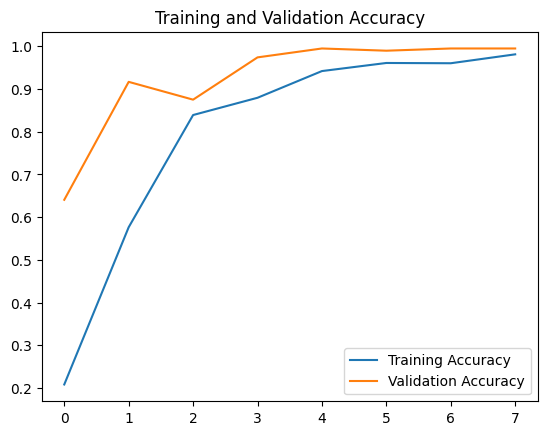

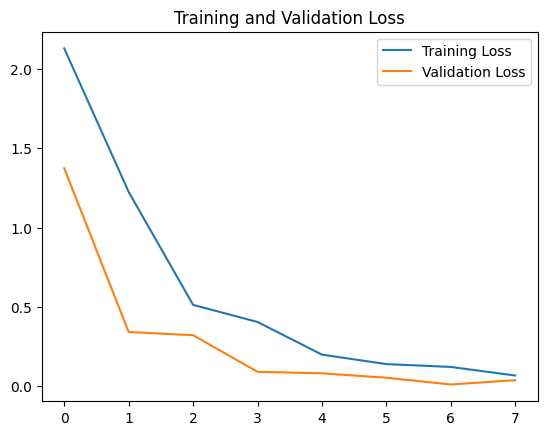

In [75]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


First image to predict
Actual Label: 06_index
1/1 [==============================] - 1s 690ms/step
Predicted Label: 06_index


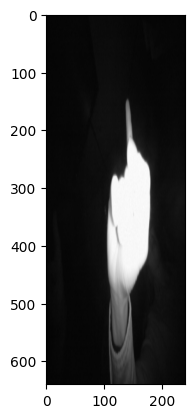

In [76]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    print("Actual Label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [77]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 44ms/step


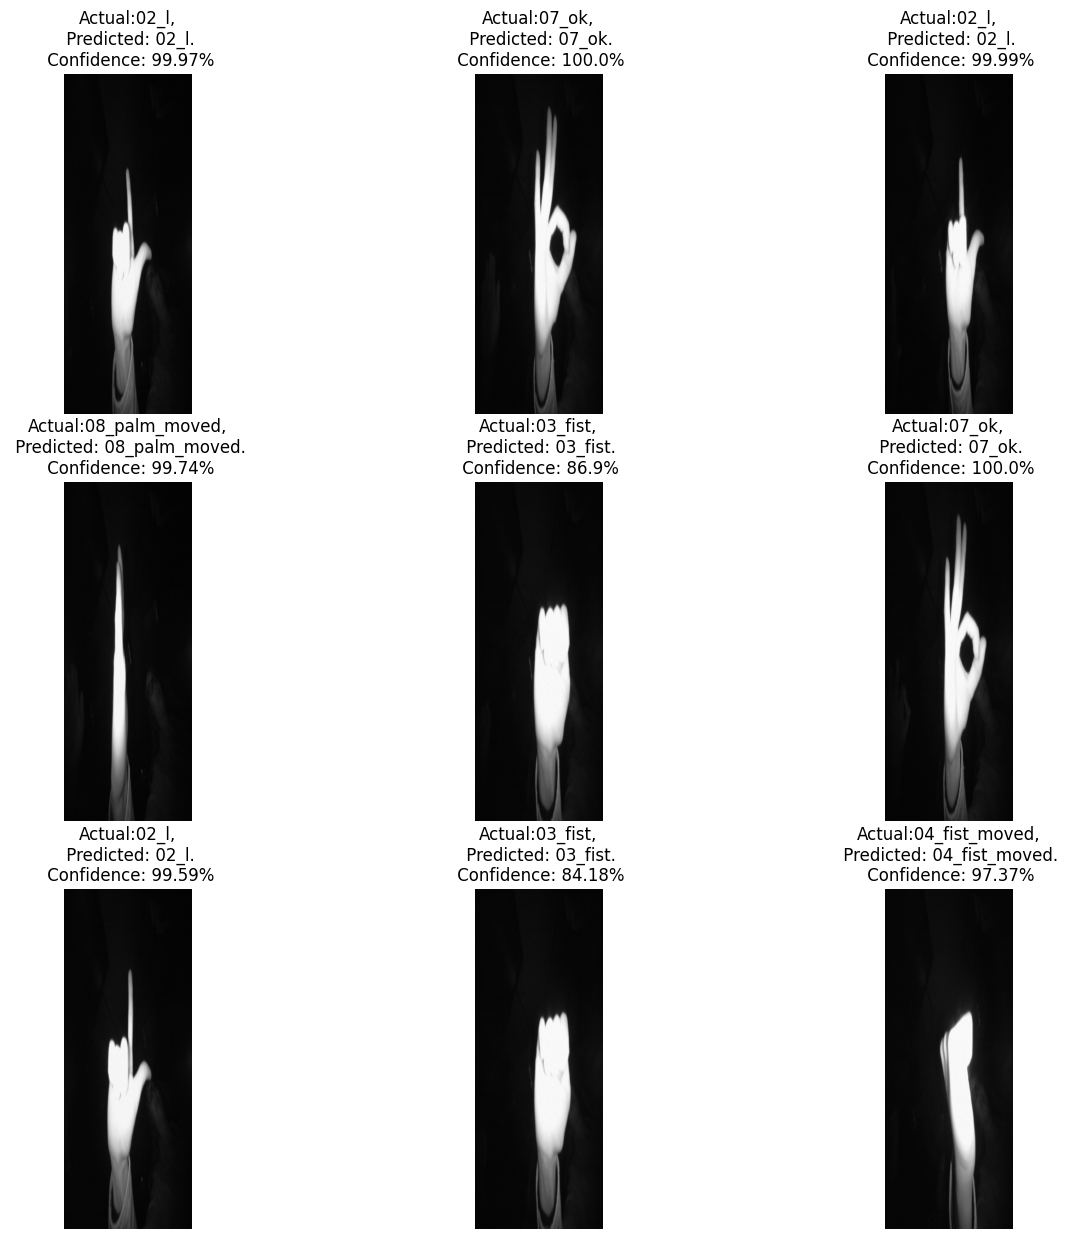

In [78]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy)
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [79]:
model.save("HANDGESTURE.h5")